In [1]:
# !pip install torch torchvision pandas matplotlib scikit-learn seaborn tensorboard pillow fvcore timm
# !pip install --upgrade tensorflow tensorboard

In [ ]:
# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# PyTorch & Related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform
from tqdm import tqdm
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import swin_v2_b, Swin_V2_B_Weights

# Computer Vision
from torchvision import transforms
from torchvision.transforms import v2
from PIL import Image

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 3090


In [4]:
os.chdir("C:\Hasnain")
print("Current working directory:", os.getcwd())

Current working directory: C:\Hasnain


In [5]:
# File paths
train_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_training_original_cross_data_full_with_augmentation.csv"
val_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_validation_original_cross_data_full_with_augmentation.csv"
test_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_testing_original_cross_data_full_with_augmentation.csv"
celebdf_path = "datasets/celebdf_v2/celeb_df_output_file.csv"
wilddeepfake_path = "datasets/wilddeepfake/wilddeepfake_test.csv"

# Hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100
alpha = 1.0  # For Beta distribution in RandomMix

# Save and log directories
SAVE_PATH = "Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth"
LOG_DIR = "Dissertation/FFHQ/Pretrained_Best/Swin_randommix_logs"

os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

writer = SummaryWriter(log_dir=LOG_DIR)

# RandomMix

In [6]:
def random_mix(images, labels, alpha=alpha):
    lam = np.random.beta(alpha, alpha)
    batch_size, _, H, W = images.size()
    index = torch.randperm(batch_size).to(images.device)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    mixed_images = images.clone()
    mixed_images[:, :, bby1:bby2, bbx1:bbx2] = images[index, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = labels, labels[index]
    return mixed_images, y_a, y_b, lam

def denormalize(img):
    img = img.clone()
    img = img * torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3, 1, 1)
    return img

def show_images(images, labels_a, labels_b, lam):
    images = images.cpu()
    labels_a = labels_a.cpu()
    labels_b = labels_b.cpu()
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i in range(len(images)):
        img = denormalize(images[i])
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"Label A: {labels_a[i]}\nLabel B: {labels_b[i]}\nLambda: {lam:.2f}")
        axes[i].axis('off')
    plt.show()


In [7]:
# ImageNet normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [8]:
# Dataset class
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        label = int(self.df.iloc[index]['label'])
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception:
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE))

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# Datasets and DataLoaders
train_dataset = DeepfakeDataset(train_csv_path, transform=train_transform)
val_dataset = DeepfakeDataset(val_csv_path, transform=val_test_transform)
test_dataset = DeepfakeDataset(test_csv_path, transform=val_test_transform)
celebdf_dataset = DeepfakeDataset(celebdf_path, transform=val_test_transform)
wilddeepfake_dataset = DeepfakeDataset(wilddeepfake_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
celebdf_loader = DataLoader(celebdf_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
wilddeepfake_loader = DataLoader(wilddeepfake_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
# Load Swin Transformer V2 Base with pretrained ImageNet weights
model = swin_v2_b(weights=Swin_V2_B_Weights.IMAGENET1K_V1)
 
# Replace head for binary classification
model.head = nn.Linear(model.head.in_features, 2)
model = model.to(device)
 
# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True
 
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
 
# Training state tracking
train_losses, val_losses, val_accuracies = [], [], []
early_stop_patience = 5
early_stop_counter = 0
best_acc = 0.0

In [11]:
# Print model parameter statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

Total parameters: 86,907,898
Trainable parameters: 2,050

Trainable parameters:
head.weight: torch.Size([2, 1024])
head.bias: torch.Size([2])


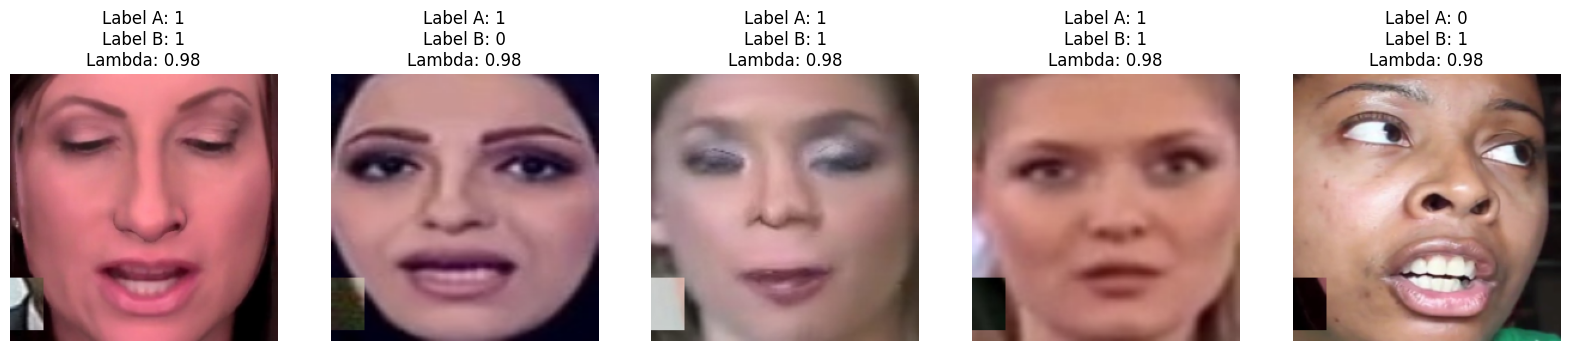

In [12]:
# Visualize RandomMix results
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

mixed_images, labels_a, labels_b, lam = random_mix(images, labels, alpha=alpha)
show_images(mixed_images[:5], labels_a[:5], labels_b[:5], lam)

In [13]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, alpha=alpha):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        mixed_images, labels_a, labels_b, lam = random_mix(images, labels, alpha=alpha)

        optimizer.zero_grad()
        outputs = model(mixed_images)

        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (lam * (predicted == labels_a).sum().item()) + ((1 - lam) * (predicted == labels_b).sum().item())

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [14]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5

# Initialize tracking lists before the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, alpha=alpha)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Accuracy/Val", val_acc, epoch)

    print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print(f" Saved best model to: {SAVE_PATH}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(" Early stopping triggered.")
            break

    scheduler.step()

writer.close()


 Epoch 1/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [04:55<00:00,  3.54it/s]


 Train Loss: 0.5560, Train Acc: 72.20%
 Val Loss: 0.3924, Val Acc: 84.61%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 2/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:33<00:00,  3.14it/s]


 Train Loss: 0.5255, Train Acc: 74.55%
 Val Loss: 0.3715, Val Acc: 86.22%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 3/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:01<00:00,  3.47it/s]


 Train Loss: 0.5203, Train Acc: 75.00%
 Val Loss: 0.3631, Val Acc: 86.52%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 4/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:44<00:00,  3.04it/s]


 Train Loss: 0.5146, Train Acc: 75.24%
 Val Loss: 0.3545, Val Acc: 86.38%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 5/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:13<00:00,  3.34it/s]


 Train Loss: 0.5142, Train Acc: 75.37%
 Val Loss: 0.3503, Val Acc: 86.59%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 6/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:22<00:00,  3.25it/s]


 Train Loss: 0.5135, Train Acc: 75.30%
 Val Loss: 0.3498, Val Acc: 87.29%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 7/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:05<00:00,  3.43it/s]


 Train Loss: 0.5124, Train Acc: 75.47%
 Val Loss: 0.3493, Val Acc: 87.17%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 8/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:07<00:00,  3.40it/s]


 Train Loss: 0.5123, Train Acc: 75.52%
 Val Loss: 0.3491, Val Acc: 87.22%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 9/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [04:48<00:00,  3.62it/s]


 Train Loss: 0.5105, Train Acc: 75.60%
 Val Loss: 0.3484, Val Acc: 87.18%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 10/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [04:58<00:00,  3.50it/s]


 Train Loss: 0.5115, Train Acc: 75.51%
 Val Loss: 0.3480, Val Acc: 87.20%
 Saved best model to: Dissertation/FFHQ/Pretrained_Best/Swin_randommix_model.pth

 Epoch 11/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:16<00:00,  3.31it/s]


 Train Loss: 0.5110, Train Acc: 75.58%
 Val Loss: 0.3486, Val Acc: 87.31%

 Epoch 12/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:30<00:00,  3.16it/s]


 Train Loss: 0.5129, Train Acc: 75.42%
 Val Loss: 0.3487, Val Acc: 87.29%

 Epoch 13/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:42<00:00,  3.06it/s]


 Train Loss: 0.5106, Train Acc: 75.58%
 Val Loss: 0.3485, Val Acc: 87.31%

 Epoch 14/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:04<00:00,  3.44it/s]


 Train Loss: 0.5107, Train Acc: 75.55%
 Val Loss: 0.3488, Val Acc: 87.30%

 Epoch 15/100


Validation: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [05:40<00:00,  3.07it/s]

 Train Loss: 0.5121, Train Acc: 75.48%
 Val Loss: 0.3486, Val Acc: 87.31%
 Early stopping triggered.


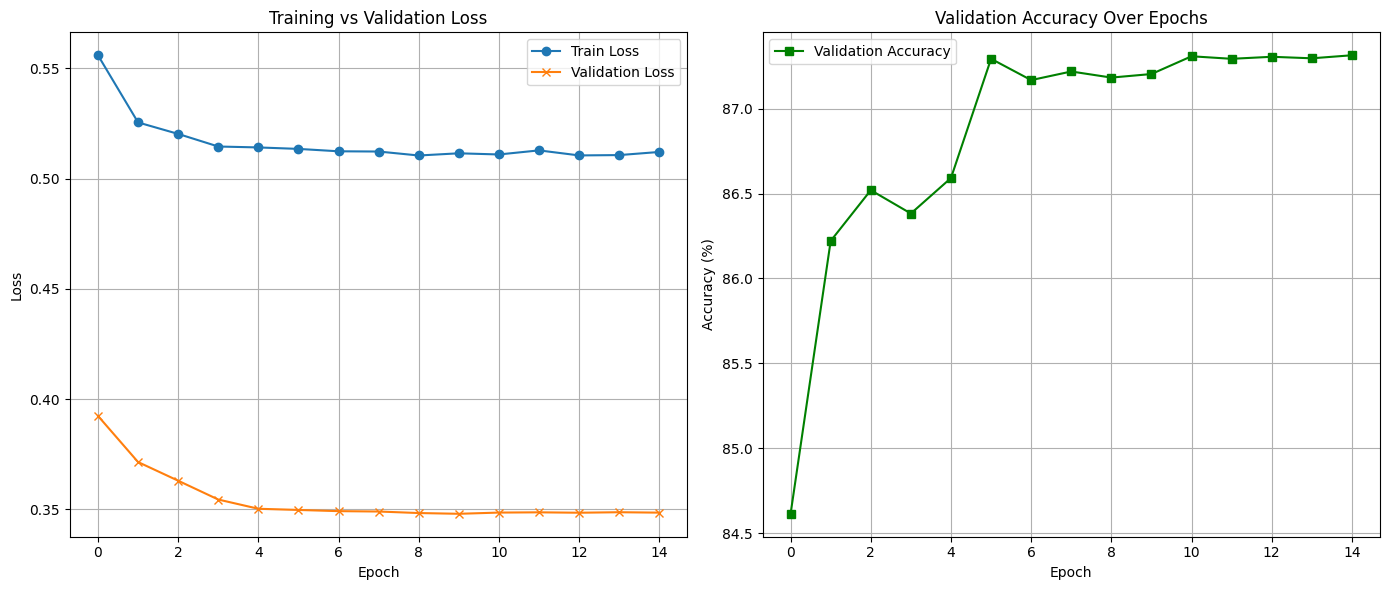

In [15]:
plt.figure(figsize=(14, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='s', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
def test_model_with_probs(model, dataloader, device, name):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_probs)

In [17]:
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    threshold = thresholds[min_index]
    return eer, threshold

def plot_combined_roc_with_eer(score_label_tuples):
    plt.figure(figsize=(7, 7))
    for y_true, y_scores, label in score_label_tuples:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc_score = roc_auc_score(y_true, y_scores)
        eer, _ = calculate_eer(y_true, y_scores)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f}, EER = {eer:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves with AUC & EER")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [18]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [19]:
# Load best model
model.load_state_dict(torch.load(SAVE_PATH))
model.to(device)

# Predict
labels_test, probs_test = test_model_with_probs(model, test_loader, device, name="FFHQ Test Set")
labels_celeb, probs_celeb = test_model_with_probs(model, celebdf_loader, device, name="CelebDF")
labels_wild, probs_wild = test_model_with_probs(model, wilddeepfake_loader, device, name="WildDeepfake")

# Thresholding
preds_test = (probs_test >= 0.5).astype(int)
preds_celeb = (probs_celeb >= 0.5).astype(int)
preds_wild = (probs_wild >= 0.5).astype(int)

WildDeepfake: 100%|████████████████████████████████████████████████████████████████| 2245/2245 [12:01<00:00,  3.11it/s]


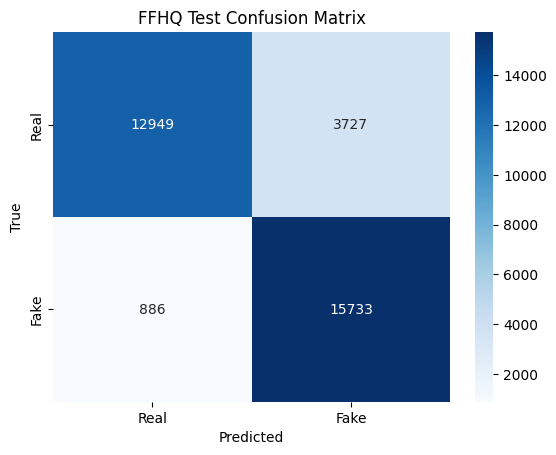

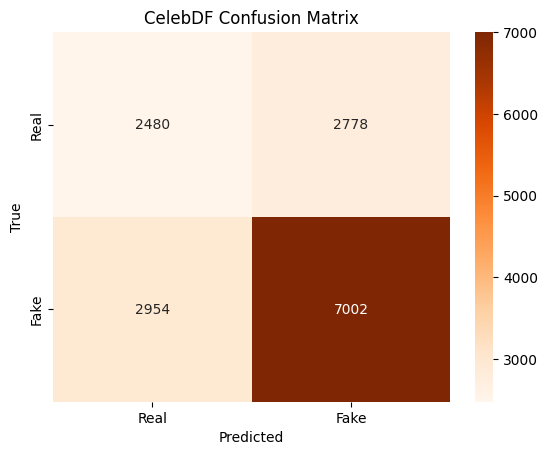

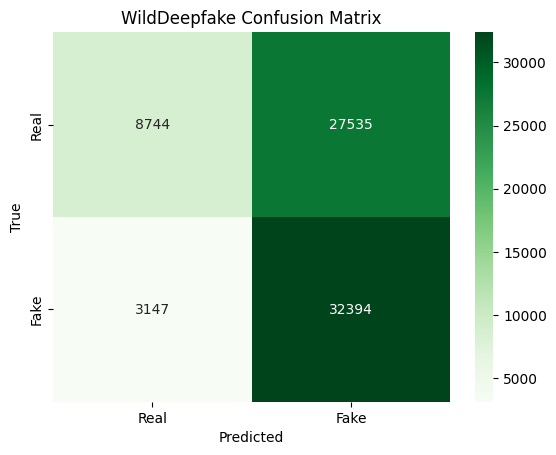

In [20]:
# Confusion Matrices
plot_confusion_matrix(labels_test, preds_test, title="FFHQ Test Confusion Matrix", cmap="Blues")
plot_confusion_matrix(labels_celeb, preds_celeb, title="CelebDF Confusion Matrix", cmap="Oranges")
plot_confusion_matrix(labels_wild, preds_wild, title="WildDeepfake Confusion Matrix", cmap="Greens")

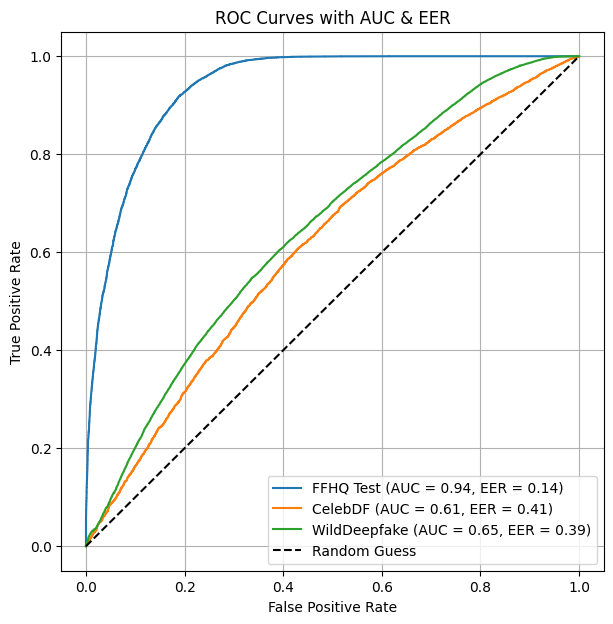

In [21]:
# ROC Curves
plot_combined_roc_with_eer([
    (labels_test, probs_test, "FFHQ Test"),
    (labels_celeb, probs_celeb, "CelebDF"),
    (labels_wild, probs_wild, "WildDeepfake")
])

In [22]:
# Classification reports

print("FFHQ Test Set Classification Report:")
print(classification_report(labels_test, preds_test, target_names=["Real", "Fake"]))

print("\nCelebDF Classification Report:")
print(classification_report(labels_celeb, preds_celeb, target_names=["Real", "Fake"]))

print("\nWildDeepfake Classification Report:")
print(classification_report(labels_wild, preds_wild, target_names=["Real", "Fake"]))

FFHQ Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.94      0.78      0.85     16676
        Fake       0.81      0.95      0.87     16619

    accuracy                           0.86     33295
   macro avg       0.87      0.86      0.86     33295
weighted avg       0.87      0.86      0.86     33295


CelebDF Classification Report:
              precision    recall  f1-score   support

        Real       0.46      0.47      0.46      5258
        Fake       0.72      0.70      0.71      9956

    accuracy                           0.62     15214
   macro avg       0.59      0.59      0.59     15214
weighted avg       0.63      0.62      0.62     15214


WildDeepfake Classification Report:
              precision    recall  f1-score   support

        Real       0.74      0.24      0.36     36279
        Fake       0.54      0.91      0.68     35541

    accuracy                           0.57     71820
   macro avg       0.6

# GradCam

In [23]:
target_layer = model.features[0][0]  # first block in features[5].norm1
target_layers = [target_layer]

for param in target_layer.parameters():
    param.requires_grad = True

cam = GradCAM(model=model, target_layers=target_layers)

def show_gradcam(loader, label_name="Sample", image_weight=0.5):
    model.eval()

    # Get a sample
    images, labels = next(iter(loader))
    img_tensor = images[0].unsqueeze(0).to(device)
    label = labels[0].item()

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        pred_label = pred_label.item()
        confidence = confidence.item()

    # Grad-CAM for predicted class
    targets = [ClassifierOutputTarget(pred_label)]
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # De-normalize image (ImageNet stats)
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)

    # Overlay Grad-CAM heatmap
    vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

    # Show plot
    plt.figure(figsize=(5, 5))
    plt.imshow(vis)
    plt.title(
        f"{label_name} Grad-CAM\n"
        f"True: {'Fake' if label == 1 else 'Real'} | "
        f"Pred: {'Fake' if pred_label == 1 else 'Real'} ({confidence:.2f})"
    )
    plt.axis("off")
    plt.show()

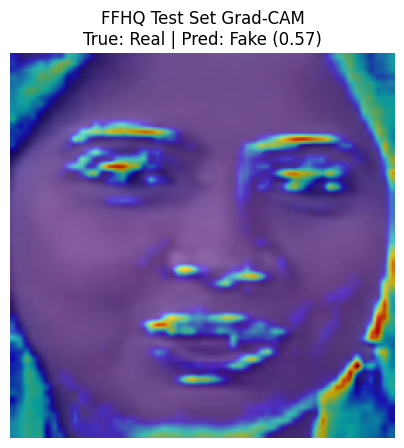

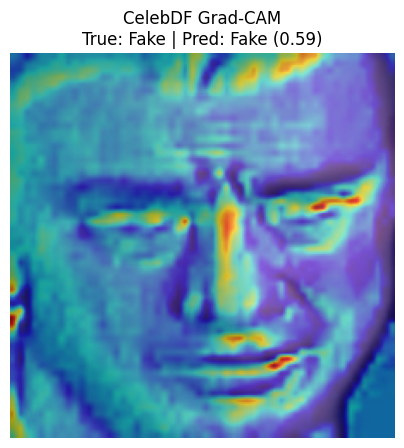

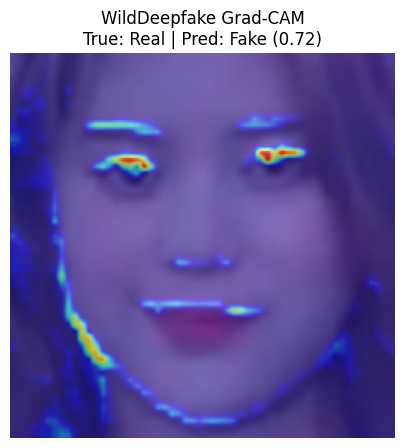

In [24]:
# Show Grad-CAM samples
show_gradcam(test_loader, "FFHQ Test Set")
show_gradcam(celebdf_loader, "CelebDF")
show_gradcam(wilddeepfake_loader, "WildDeepfake")

In [25]:
def show_batch_gradcam(loader, title="Batch Grad-CAM", image_weight=0.5):
    model.eval()
    all_images, all_labels = [], []

    # Collect up to 1000 samples
    for imgs, lbls in loader:
        all_images.extend(imgs)
        all_labels.extend(lbls)
        if len(all_images) >= 1000:
            break

    # Sample 4 fake + 4 real
    indices_fake = [i for i, l in enumerate(all_labels) if l == 1]
    indices_real = [i for i, l in enumerate(all_labels) if l == 0]

    num_fake = min(4, len(indices_fake))
    num_real = min(4, len(indices_real))
    chosen_indices = random.sample(indices_fake, num_fake) + random.sample(indices_real, num_real)
    random.shuffle(chosen_indices)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, idx in zip(axes.flatten(), chosen_indices):
        img = all_images[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx].item()

        # Get prediction
        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)
            confidence, pred_label = torch.max(probs, 1)
            pred_label = pred_label.item()
            confidence = confidence.item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(pred_label)])[0]

        # De-normalize (ImageNet stats)
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        # Overlay CAM
        vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

        ax.imshow(vis)
        ax.set_title(
            f"True: {'Fake' if true_label else 'Real'}\n"
            f"Pred: {'Fake' if pred_label else 'Real'} ({confidence:.2f})",
            fontsize=12
        )
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

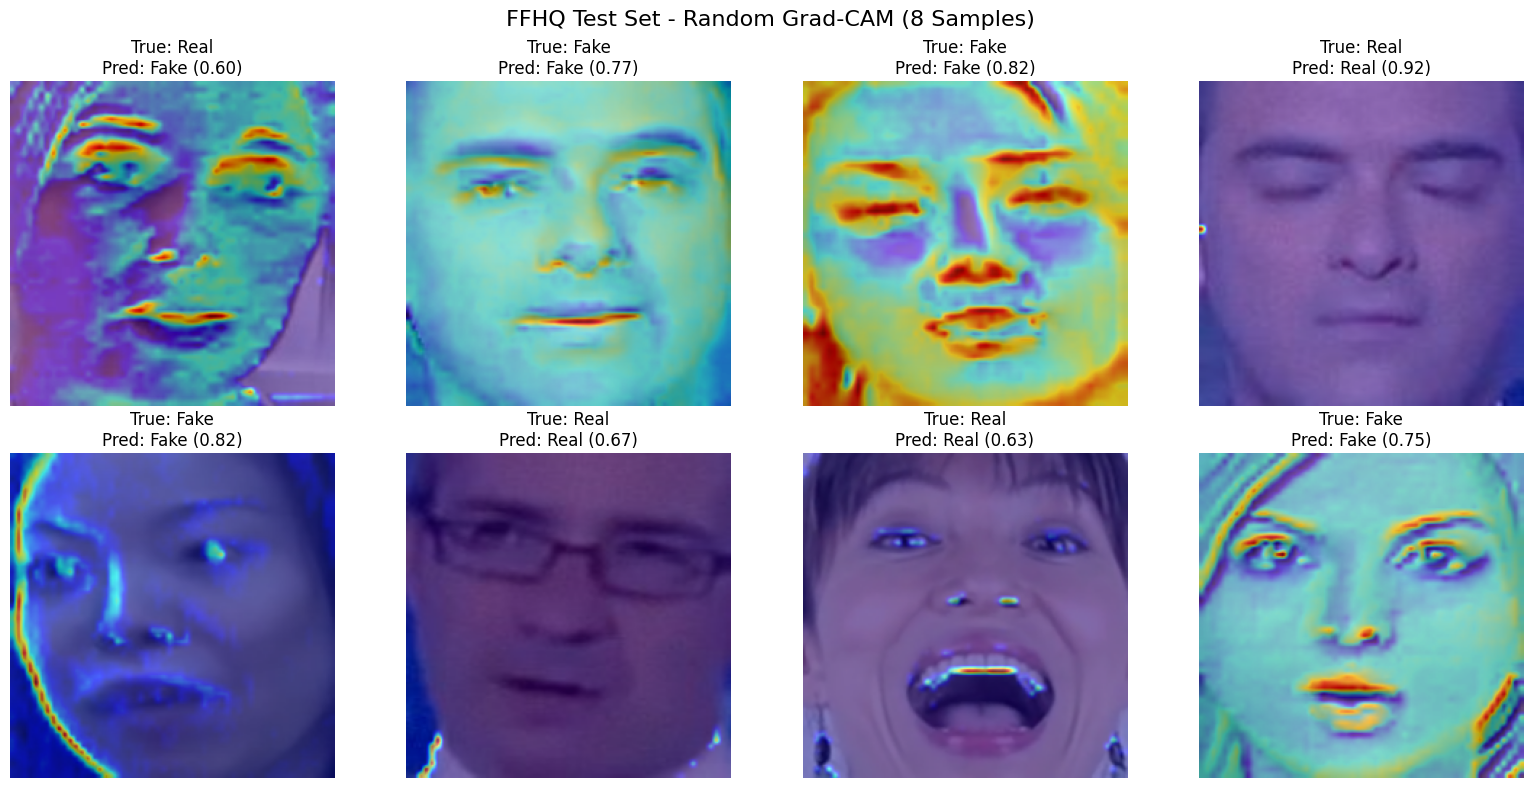

In [26]:
show_batch_gradcam(test_loader, title=" FFHQ Test Set - Random Grad-CAM (8 Samples)")

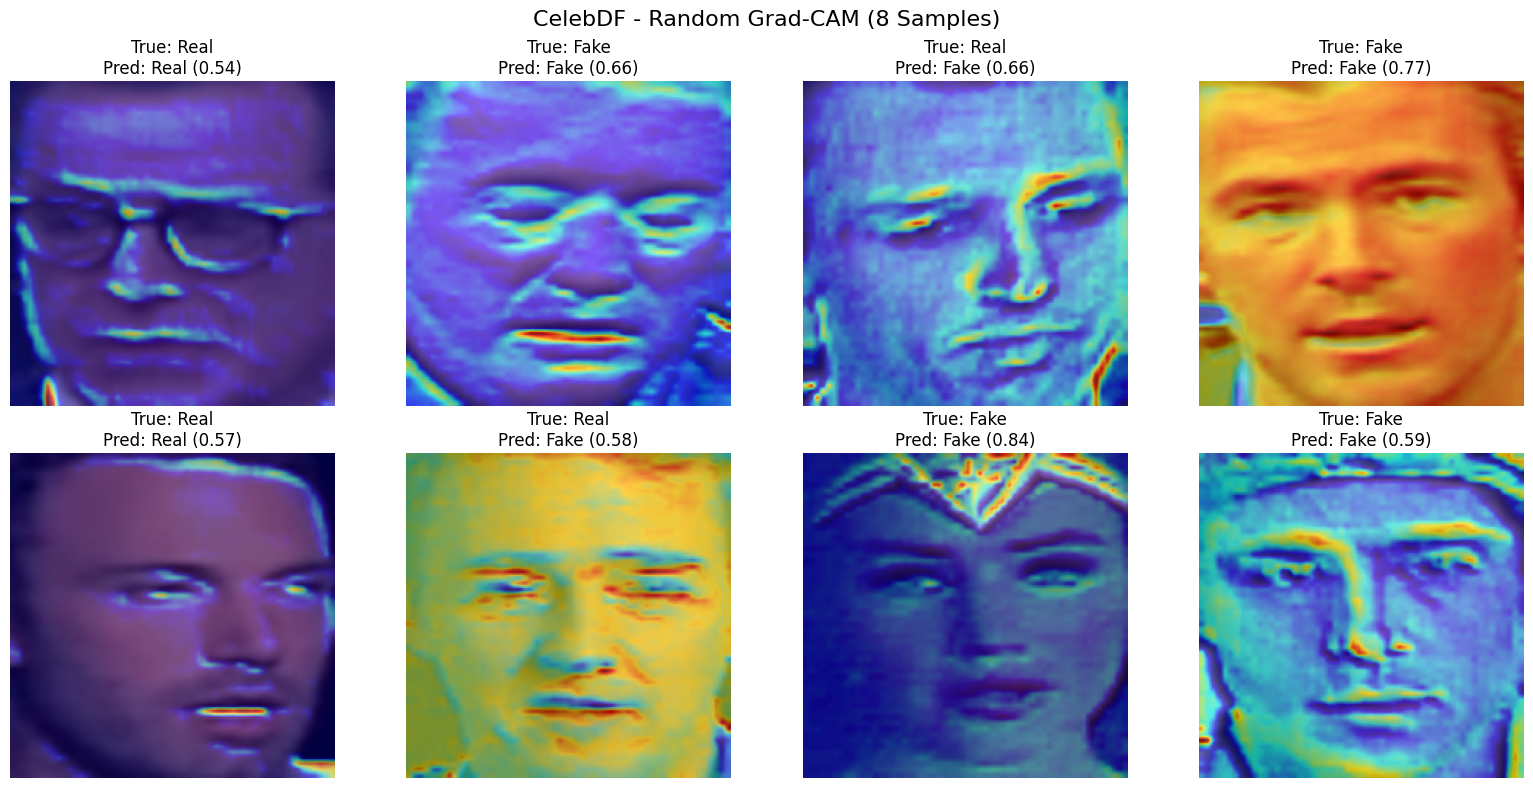

In [27]:
show_batch_gradcam(celebdf_loader, title="CelebDF - Random Grad-CAM (8 Samples)")

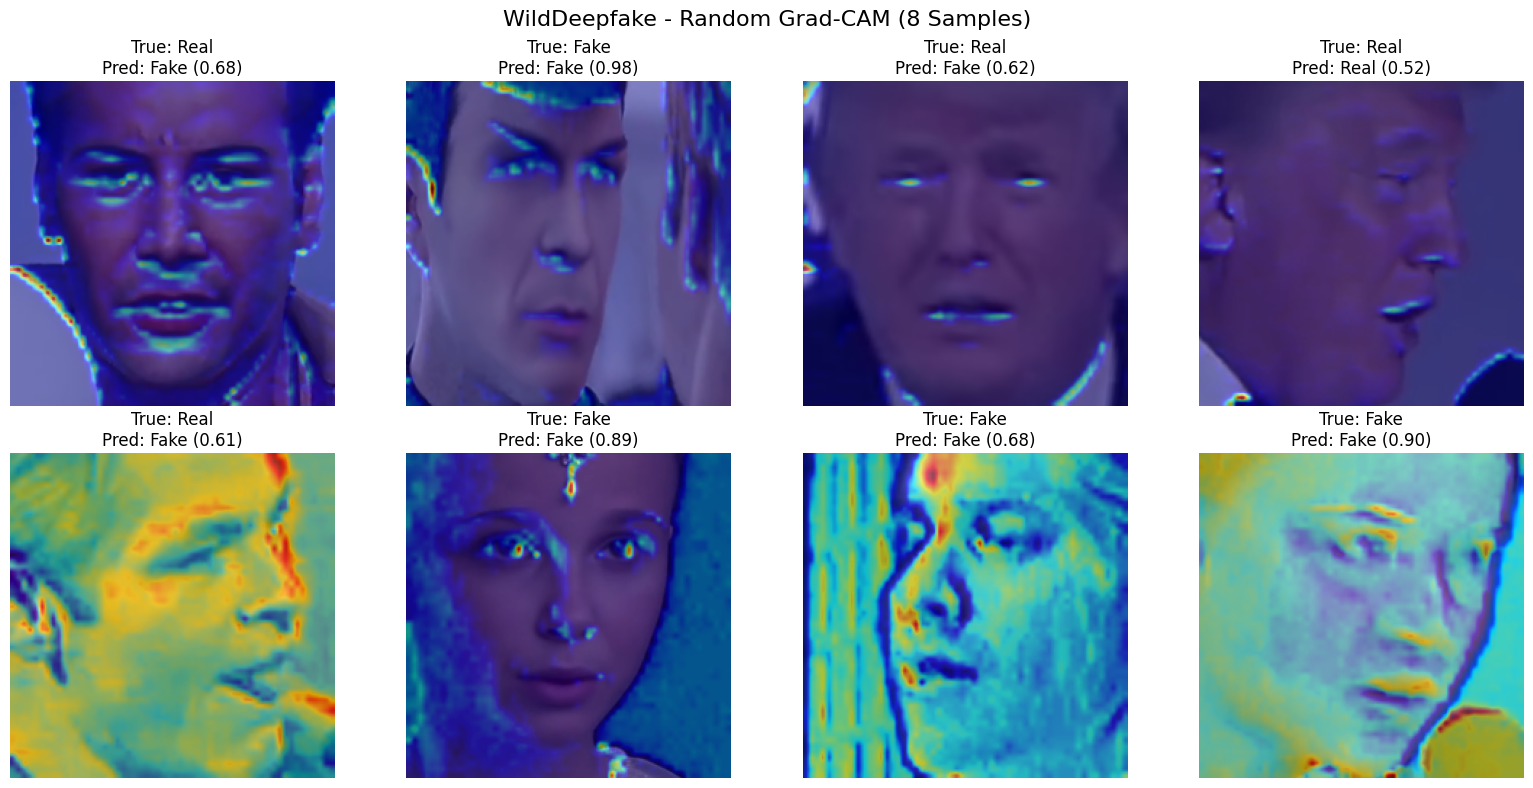

In [28]:
show_batch_gradcam(wilddeepfake_loader, title="WildDeepfake - Random Grad-CAM (8 Samples)")